<a href="https://colab.research.google.com/github/junggeyy/DeepLearning/blob/main/mlp_number_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a Multilayer Perceptron (MNIST)

In this notebook, I am using the classic MNIST dataset to test and train a MLP to recognize handwritten digits.

## Loading the Dataset

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    root="./mnist", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./mnist", train=False, transform=transforms.ToTensor()
)

In [6]:
import torch
from torch.utils.data.dataset import random_split

torch.manual_seed(1)
tain_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [8]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

## Checking the label distribution

In [11]:
from collections import Counter

train_counter = Counter()
for images, labels in train_loader:
  train_counter.update(labels.tolist())

print("\nTrain label distribution:")
print(sorted(train_counter.items()))

val_counter = Counter()
for images, labels in val_loader:
  val_counter.update(labels.tolist())

print("\nValidation label distribution:")
print(sorted(val_counter.items()))

test_counter = Counter()
for images, labels in test_loader:
  test_counter.update(labels.tolist())

print("\nTest label distribution:")
print(sorted(test_counter.items()))


Train label distribution:
[(0, 5923), (1, 6742), (2, 5958), (3, 6131), (4, 5842), (5, 5421), (6, 5918), (7, 6265), (8, 5851), (9, 5949)]

Validation label distribution:
[(0, 504), (1, 557), (2, 481), (3, 450), (4, 493), (5, 447), (6, 496), (7, 555), (8, 500), (9, 517)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


## Visulatizing the Dataset

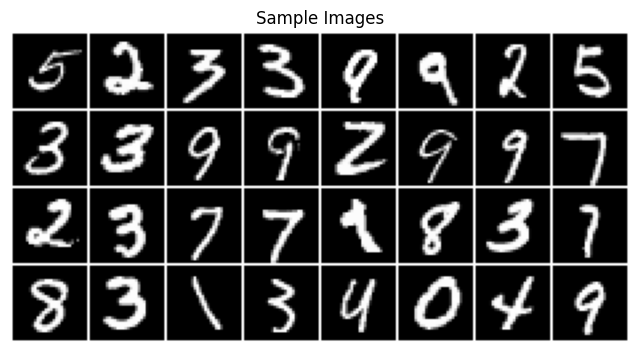

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

for images, labels in train_loader:
  break

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Sample Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:32],
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

## Implementing the Model

In [15]:
images.shape

torch.Size([64, 1, 28, 28])

We can see that the images are of shape: [batchsize, channel, height, width]
<br>For simplicity we reshape/flatten the 28*28 size 1 channel image into a single dim vector

In [16]:
import torch

torch.flatten(images, start_dim=1).shape # batchsize, features

torch.Size([64, 784])

In [21]:
class PyTorchMLP(torch.nn.Module):

  def __init__(self, num_features, num_classes):
    super().__init__()
    self.all_layers = torch.nn.Sequential(

        torch.nn.Linear(num_features, 50),
        torch.nn.ReLU(),

        torch.nn.Linear(50, 25),
        torch.nn.ReLU(),

        torch.nn.Linear(25, num_classes),
    )

  def forward(self, x):
    x = torch.flatten(x, start_dim = 1)
    logits = self.all_layers(x)
    return logits

## Training Loop

In [23]:
def compute_accuracy(model, dataloader):
  model = model.eval()

  correct = 0.0
  total_examples = 0.0

  for idx, (features, labels) in enumerate(dataloader):

    with torch.inference_mode():
      logits = model(features)

    predictions = torch.argmax(logits, dim=1)

    compare = (labels == predictions)
    correct += torch.sum(compare)
    total_examples += len(compare)

  return correct / total_examples

In [ ]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=784, num_classes=10)
optimzer = torch.optim.SGD(model.parameters(), lr=0.05)

num_epochs = 10

for epoch in range(num_epochs):
  model.train()

  for batch_idx, (features, labels) in enumerate(train_loader):
    logits = model(features)
    loss = F.cross_entropy(logits, labels)

    optimzer.zero_grad()
    loss.backward()
    optimzer.step()

    # Logging
    if not batch_idx % 250:
      print(f'{epoch+1:003d}/{num_epochs:003d}'
            f' | Batch {batch_idx:03d}/{len(train_loader):03d}'
            f' | Loss: {loss:.2f}')

  train_accuracy = compute_accuracy(model, train_loader)
  val_accuracy = compute_accuracy(model, val_loader)
  print(f"Test Accuracy: {train_accuracy*100:.2f}%")
  print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

## Evaluating the results

In [25]:

train_accuracy = compute_accuracy(model, train_loader)
val_accuracy = compute_accuracy(model, val_loader)
test_accuracy = compute_accuracy(model, test_loader)
print(f"Test Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Test Accuracy: 97.17%
Validation Accuracy: 96.96%
Test Accuracy: 96.30%
